# CS543 Final Project CP1

04-14-2019

Yu Chen, Yu Chen, Yite Wang, Yuan Zhang

yuc5@illinois.edu; yuc6@illinois.edu; yitew2@illinois.edu; yuanz4@illinois.edu; 

## Include libraries

In [50]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rot
import cv2
import re
import math
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## Functions

In [57]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
        
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])         
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])          
    R = np.dot(R_z, np.dot( R_y, R_x ))
    return R

def solve(index,r_old1,r_old2,t_old1):
    IMG_DIR = 'image_0/'
    num1 = str(index)
    num2 = str(index+1)
    num1_0 = 6-len(num1)
    num2_0 = 6-len(num2)
    IMG_NAME_1 = '0'*num1_0 + num1 + '.png'
    IMG_NAME_2 = '0'*num2_0 + num2 + '.png'

    img_1 = cv2.imread(IMG_DIR + IMG_NAME_1)
    img_2 = cv2.imread(IMG_DIR + IMG_NAME_2)

    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img_1,None)
    kp2, des2 = sift.detectAndCompute(img_2,None)
    
    # Apply sharpening filter if feature count is low
    if len(kp1) <= 1700:
        img_1b = cv2.GaussianBlur(img_1,(5,5), 2)
        img_1 = cv2.addWeighted(img_1, 2, img_1b, -1, 0)
        img_2b = cv2.GaussianBlur(img_2,(5,5), 2)
        img_2 = cv2.addWeighted(img_2, 2, img_2b, -1, 0)
        kp1, des1 = sift.detectAndCompute(img_1,None)
        kp2, des2 = sift.detectAndCompute(img_2,None)

    # Adaptive threshold for finding feasible FLANN matches
    dis_Threshold = 0.8+((1600-len(kp1))/6250)
    dis_Threshold = np.clip(dis_Threshold,0.75,0.85)
     
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
    search_params = dict(checks=30)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < dis_Threshold*n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
    pts1_E = np.asarray(pts1)
    pts2_E = np.asarray(pts2)
    
    E, mask = cv2.findEssentialMat(pts1_E, pts2_E, focal=fl, pp=pp)
    _, R, t, _ = cv2.recoverPose(E, pts1_E, pts2_E, focal=fl, pp=pp, mask=mask)

    # Egomotion adpative post-processing
    t = t.reshape(3)
    t[2] = abs(t[2])
    Angle = rotationMatrixToEulerAngles(R)

    # Noise processing and trim pi
    Angle[Angle>=(np.pi)] = Angle[Angle>=(np.pi)]-np.pi
    Angle[Angle<=(-np.pi)] = Angle[Angle<=(-np.pi)]+np.pi
    #Angle[abs(Angle)<= 0.0002] = 0
    Angle = np.clip(Angle, -0.2*np.pi, 0.2*np.pi)
    
    if pts1_E.shape[0] <= 900:
        # Apply 3 moving average
        Ao1 = rotationMatrixToEulerAngles(r_old1)
        Ao2 = rotationMatrixToEulerAngles(r_old2)
        Angle = (Ao1 + Ao2 + 2*Angle) / 4
        
    elif pts1_E.shape[0] <= 600:
        # Apply 3 moving average
        Ao1 = rotationMatrixToEulerAngles(r_old1)
        Ao2 = rotationMatrixToEulerAngles(r_old2)
        Angle = (2*Ao1 + Ao2 + Angle) / 4

    R = eulerAnglesToRotationMatrix(Angle)

    return E, R, t

## Read camera parameters

In [58]:
# Find Intrinsic Parameters
CamP = np.loadtxt('KITTI  sample dataset/dataset/sequences/00/calib.txt','str')[:,1:].astype(np.float)
P0 = CamP[0,:].reshape((3,4))
fl = P0[0, 0]
pp = (P0[0, 2], P0[1, 2])

## Read from Ground Truth

In [59]:
ReadGT = np.loadtxt('KITTI  sample dataset/dataset/poses/00.txt')
Rs = np.reshape(ReadGT,(3*len(ReadGT),4))[:,:-1]
translation = np.reshape(np.reshape(ReadGT,(3*len(ReadGT),4))[:,-1:],(len(ReadGT),3))
rotation = np.zeros([len(ReadGT),3,3])
rotation[0:len(ReadGT),0,:] = Rs[::3,:]
rotation[0:len(ReadGT),1,:] = Rs[1::3,:]
rotation[0:len(ReadGT),2,:] = Rs[2::3,:]

## Main

In [60]:
index0 = 0
index = 1000
NEW_OPTICAL = True

N = 3
E = np.zeros((index, 3, 3))
r = np.zeros((index, 3, 3))
r_old1 = np.zeros((3, 3))
r_old2 = np.zeros((3, 3))

t_old1 = np.zeros(3)

t0 = np.zeros((index, 3))
t = np.zeros((index-(N-1), 3))

if NEW_OPTICAL is True:
    for i in range(index0,index):
        E[i], r[i], t0[i] = solve(i,r_old1,r_old2,t_old1)
        if i >= N:
            r_old1 = r[i]
            r_old2 = r_old1
            t_old1 = t0[i]

        if i % (index/100) == 0:
            logging.info(' '+str(100*i/index)+'%  Processed - ' + str(i))
        elif (i == index-1):
            print('--> 100% Done')
    
    # Apply 3 moving average on translation
    t[:,0] = np.convolve(t0[:,0], np.ones((N,))/N, mode='valid') 
    t[:,1] = np.convolve(t0[:,1], np.ones((N,))/N, mode='valid') 
    t[:,2] = np.convolve(t0[:,2], np.ones((N,))/N, mode='valid') 
    t = np.append(t,t0[(index-(N-1)):index,:], axis=0)

    np.save('0-249/E_0-249', E)
    np.save('0-249/r_0-249', r)
    np.save('0-249/t_0-249', t)
    
else:
    E = np.load('0-249/E_0-249.npy')
    r = np.load('0-249/r_0-249.npy')
    t = np.load('0-249/t_0-249.npy')

INFO:root: 0.0%  Processed - 0
INFO:root: 1.0%  Processed - 10
INFO:root: 2.0%  Processed - 20
INFO:root: 3.0%  Processed - 30
INFO:root: 4.0%  Processed - 40
INFO:root: 5.0%  Processed - 50
INFO:root: 6.0%  Processed - 60
INFO:root: 7.0%  Processed - 70
INFO:root: 8.0%  Processed - 80
INFO:root: 9.0%  Processed - 90
INFO:root: 10.0%  Processed - 100
INFO:root: 11.0%  Processed - 110
INFO:root: 12.0%  Processed - 120
INFO:root: 13.0%  Processed - 130
INFO:root: 14.0%  Processed - 140
INFO:root: 15.0%  Processed - 150
INFO:root: 16.0%  Processed - 160
INFO:root: 17.0%  Processed - 170
INFO:root: 18.0%  Processed - 180
INFO:root: 19.0%  Processed - 190
INFO:root: 20.0%  Processed - 200
INFO:root: 21.0%  Processed - 210
INFO:root: 22.0%  Processed - 220
INFO:root: 23.0%  Processed - 230
INFO:root: 24.0%  Processed - 240
INFO:root: 25.0%  Processed - 250
INFO:root: 26.0%  Processed - 260
INFO:root: 27.0%  Processed - 270
INFO:root: 28.0%  Processed - 280
INFO:root: 29.0%  Processed - 290
I

--> 100% Done


## Generate trajectory from results

In [63]:
T = np.zeros(3)
R = np.eye(3)
T_list = np.zeros((index, 3))
R_list = np.zeros((index, 3, 3))
for i in range(index0,index):
    T += R @ t[i]
    R = R @ r[i]
    T_list[i] = T
    R_list[i] = R

## Trajectory validation

<IPython.core.display.Javascript object>


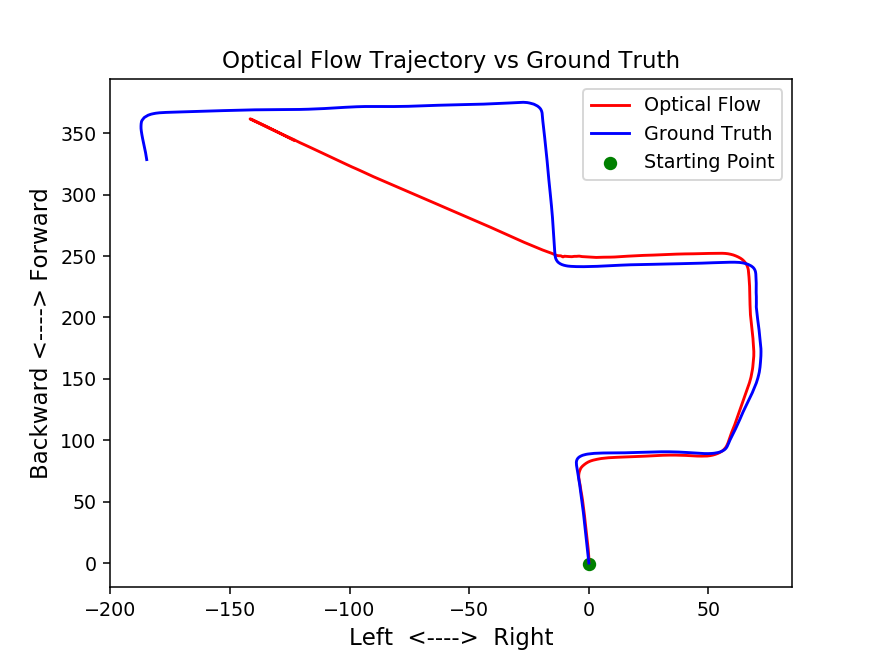

In [64]:
#scaling factor to remedy focal length unit conversion
Scaling1 = 0.6 
Scaling2 = 0.75 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(T_list[0,0], -T_list[0,2], c='g')
ax.plot(-Scaling1*T_list[:,0], Scaling2*T_list[:,2],c='r')
ax.plot(translation[index0:index,0], translation[index0:index,2],c='b')
plt.legend(['Optical Flow','Ground Truth','Starting Point'])
plt.title('Optical Flow Trajectory vs Ground Truth')
plt.xlabel('Left  <---->  Right', fontsize='12')
plt.ylabel('Backward <----> Forward', fontsize='12')
plt.show()